# Home Assignment 

### Name: Anushk Naval  
### Roll:18046

**Perform the atmospheric correction over Bhopal region using LANDSAT imagery**

Readme:<br>
The program takes all the data from metafile and the tiff image, input the file name in standard format.

## Imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math

In [2]:
file_path = input('Enter file path:')
filename = input('Enter file name without extension:')
O_img = Image.open(file_path+filename+'.tif')

Enter file path:
Enter file name without extension:LC08_L1TP_145044_20210120_20210120_01_RT_B3


## Information Extraction and initialization:

In [3]:
imarray = np.array(O_img)

In [4]:
landsat_no = int(filename[3])

In [5]:
band = filename[-1]

In [6]:
meta_fn = filename[:-2] + 'MTL.txt'

In [7]:
meta_lines = []
with open(file_path+meta_fn,'rt') as metafile:
    for i in metafile:
        meta_lines.append(i)

In [8]:
for line in meta_lines:
    line = line.strip()
    if line.startswith('RADIANCE_MULT_BAND_'+band):
        pieces = line.split()
        rmb = float(pieces[2])
    elif line.startswith('RADIANCE_ADD_BAND_'+band):
        pieces = line.split()
        rab = float(pieces[2])
    elif line.startswith('EARTH_SUN_DISTANCE'):
        pieces = line.split()
        d = float(pieces[2])
    elif line.startswith('SUN_ELEVATION'):
        pieces = line.split()
        theta = float(pieces[2])
        phi = (90 - theta)*math.pi/180
    elif line.startswith('RADIANCE_MAXIMUM_BAND_'+band):
        pieces = line.split()
        Lmax = float(pieces[2])
    elif line.startswith('RADIANCE_MINIMUM_BAND_'+band):
        pieces = line.split()
        Lmin = float(pieces[2])
    elif line.startswith('QUANTIZE_CAL_MAX_BAND_'+band):
        pieces = line.split()
        DNmax = float(pieces[2])
    elif line.startswith('QUANTIZE_CAL_MIN_BAND_'+band):
        pieces = line.split()
        DNmin = float(pieces[2])

In [9]:
print(landsat_no,rmb,rab,d,phi,Lmax,Lmin,DNmax,DNmin)

8 0.012236 -61.18202 0.9839947 0.874849217620906 740.73071 -61.16978 65535.0 1.0


In [10]:
if (landsat_no == 7):
    if band == 1:
        ESUN = 1970
    elif band == 2:
        ESUN = 1842
    elif band == 3:
        ESUN = 1547
    elif band == 4:
        ESUN = 1044
    elif band == 5:
        ESUN = 225.7
    elif band == 7:
        ESUN = 82.06
    elif band == 8:
        ESUN = 1369

## Step 1:DN to radiance

**Gain and Bais method**<br>
$$L = (DN * G) + B$$<br>
**Spectral radiance scaling**<br>
$$L = \frac{L_{max} - L_{min}}{DN_{max} - DN_{min}}*(DN - DN_{min})+L_{min}$$<br>
where,<br>
L = at sensor spectral radiance ($Watts/( m^{2}· srad · μm$));<br>
G = slope of the calibration function (channel gain);<br>
B = intercept of the calibration function (channel offset);<br>
$L_{max}$ and $L_{min}$ = maximum and minimum radiance;<br>
$DN_{max}$ and $DN_{min}$ = maximum and minimum DN (digital number) value.<br>


In [11]:
def g_and_b(img, G, B):
    img_e = img.copy()
    img_e = (img_e*G) + B    
    return img_e

In [12]:
def srs(img):
    img_srs = img.copy()
    img_srs = (img_srs-DNmin)*((Lmax-Lmin)/(DNmax-DNmin)) + Lmin
    return img_srs

## Step 2: Radiance to ToA relectance

### For Landsat 1-7:

$$ρ =\frac{π*L*d^{2}}{ESUN * cos(φ)}$$<br>
Where,<br>
π = 3.14;<br>
ρ is the reflectance at the satellite;<br>
L is the radiance image;<br>
d is the Earth-sun distance;<br>
ESUN is the mean solar exo-atmospheric irradiance;<br>
φ is the sun’s angle from zenith.

In [13]:
def r_toa_r(img, d, ESUN, phi):
    img_a = img.copy()
    for i in range(height):
        for j in range(width):
            img_a[i][j] = (math.pi * img_a[i][j]* (d**2))/(ESUN * math.cos(phi))
    
    return img_a

### For Landsat 8:

$$ρ = (DN * G) + B$$<br>
where,<br>
ρ is TOA planetary reflectance.<br>
Note that ρ does not contain a correction for the sun angle.<br>
G is Band-specific multiplicative rescaling factor from the metadata
(REFLECTANCE MULT BAND);<br>
B is Band-specific additive rescaling factor from the metadata
(REFLECTANCE ADD BAND).

$$ρ_{corrected} = \frac{ρ}{cos(φ)}$$<br>
where,<br>
$ρ_{corrected}$ is the sun angle corrected reflectance;<br>
ρ is the TOA spectral reflectance;<br>
φ is the sun’s angle from zenith;<br>
φ= 90$^{o}$−θ (θ is the sun elevation angle).

In [14]:
def ro_cor(img, phi):
    img_ac = img/math.cos(phi)
    return img_ac

## Processing and Visualing:

In [15]:
if (landsat_no == 8):
    img_gnb = g_and_b(imarray,rmb,rab) # ρ
    img_ac = ro_cor(img_gnb, phi) #ρ_corrected
else:
    img_gnb = g_and_b(imarray,rmb,rab)
    img_rToA = r_toa_r(img_gnb,d, ESUN,phi)

In [16]:
print(np.max(imarray),'->',np.max(img_gnb),'->',np.max(img_ac))

20985 -> 195.59044000000003 -> 305.07970863984195


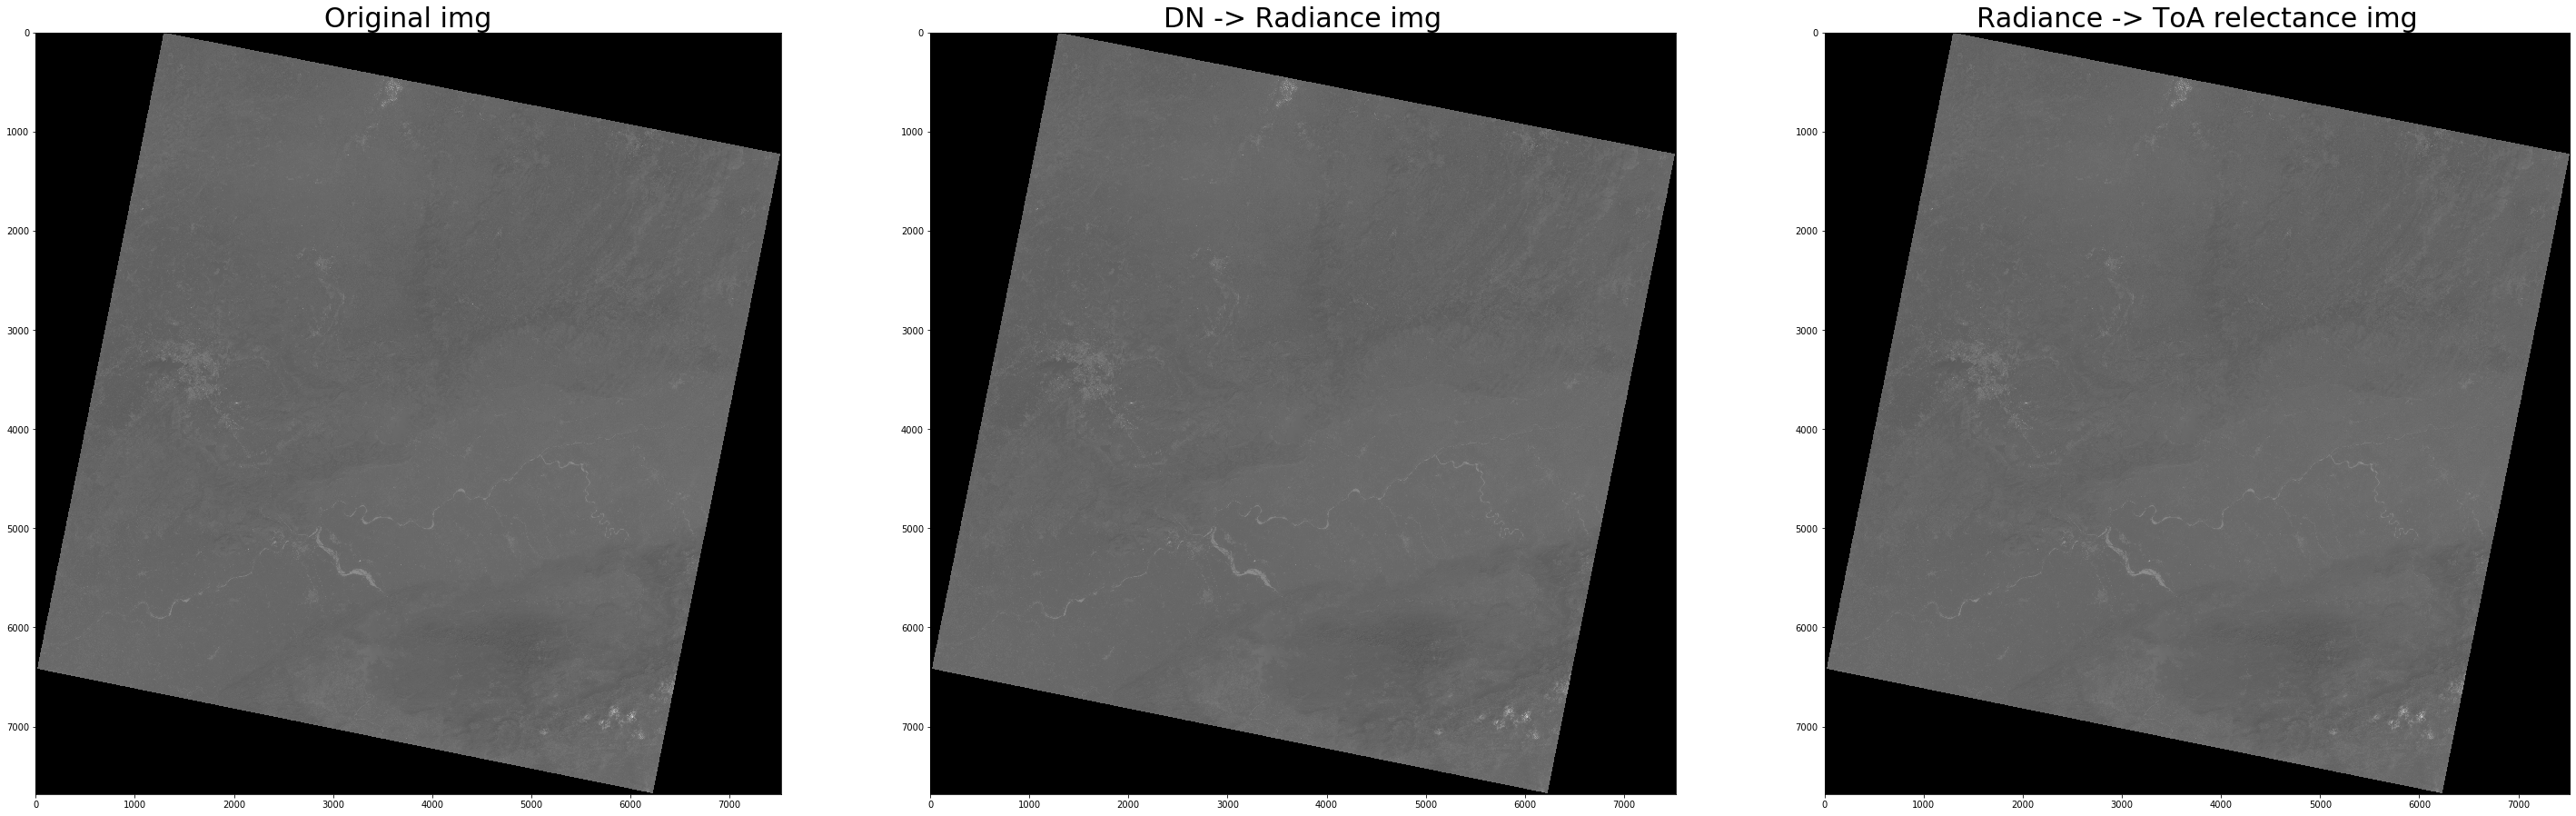

In [17]:
plt.figure(figsize=(50, 40))


plt.subplot(231)
plt.title('Original img',fontsize = 30)
plt.imshow(imarray, cmap='gray')

plt.subplot(232)
plt.title('DN -> Radiance img',fontsize = 30)
plt.imshow(img_gnb, cmap='gray')

plt.subplot(233)
plt.title('Radiance -> ToA relectance img',fontsize = 30)
plt.imshow(img_ac, cmap='gray')

plt.show()

Through atmospheric correction the effects of the reflectance value were removed, the image became more sharper and the contrast is adjusted to provide more information then the original image.